In [8]:
pip install pandasql 

Defaulting to user installation because normal site-packages is not writeable
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26896 sha256=1869c3accb430abae155f920753f3e7f44046297a3f7cec559ca648bcc747f31
  Stored in directory: c:\users\sherv\appdata\local\pip\cache\wheels\b4\d0\8c\a6b366870bf041849cd96e03b71641e082f8d6456269b603b7
Successfully built pandasql
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import openpyxl as pxl 
import pandasql as ps

In [3]:
# Load data
df = pd.read_excel("C:/Users/sherv/Downloads/Superstore Sales.xlsx")

# Check and handle missing values
df = df.dropna()  # or use df.fillna() based on context

In [4]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

# Add a profit margin column first
df['ProfitMargin'] = df['Profit'] / df['Sales']

# Query: Average profit margin by category and sub-category
query = """
SELECT Category, `Sub-Category`, 
       ROUND(AVG(ProfitMargin), 4) AS Avg_ProfitMargin
FROM df
GROUP BY Category, `Sub-Category`
ORDER BY Avg_ProfitMargin ASC
"""
profit_margins = pysqldf(query)

In [13]:
profit_margins

,Category,Sub-Category,Avg_ProfitMargin
0,Office Supplies,Binders,-0.1996
1,Office Supplies,Appliances,-0.1569
2,Furniture,Tables,-0.1477
3,Furniture,Bookcases,-0.1266
4,Technology,Machines,-0.0720
5,Furniture,Chairs,0.0439
6,Office Supplies,Storage,0.0891
7,Office Supplies,Supplies,0.1120
8,Technology,Phones,0.1192
9,Furniture,Furnishings,0.1371


In [5]:
# Example: Simulate Inventory Days
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])
df['InventoryDays'] = (df['Ship Date'] - df['Order Date']).dt.days

# Correlation
correlation = df[['InventoryDays', 'Profit']].corr()

In [15]:
correlation

,InventoryDays,Profit
InventoryDays,1.000000,0.020536
Profit,0.020536,1.000000


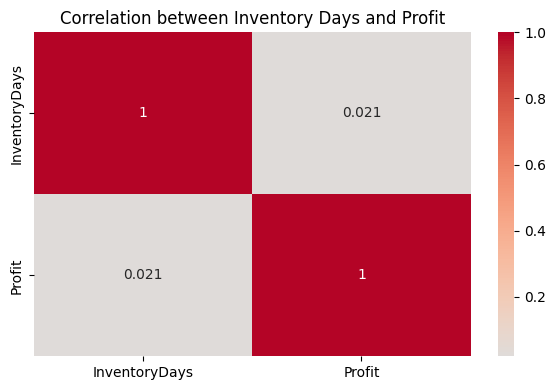

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the relevant columns
corr_matrix = df[['InventoryDays', 'Profit']].corr()

# Plot the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation between Inventory Days and Profit")
plt.tight_layout()
plt.show()


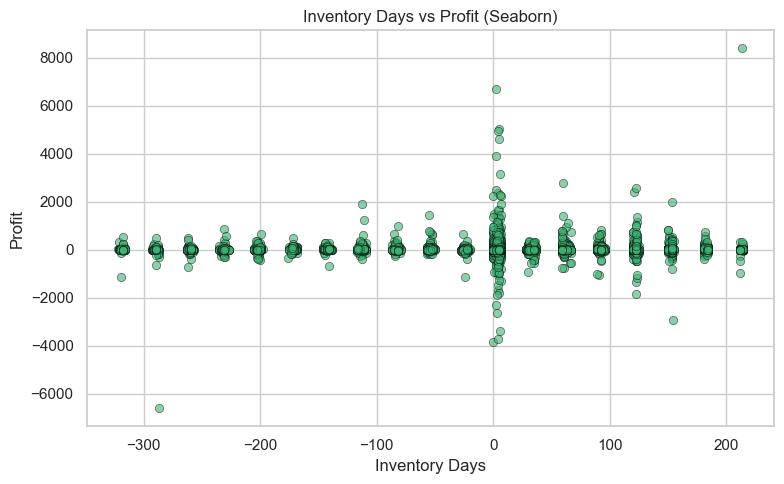

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='InventoryDays', y='Profit', color='mediumseagreen', edgecolor='black', alpha=0.6)
plt.title("Inventory Days vs Profit (Seaborn)")
plt.xlabel("Inventory Days")
plt.ylabel("Profit")
plt.tight_layout()
plt.show()


In [17]:
# Step 1: Define thresholds
inventory_days_threshold = df['InventoryDays'].quantile(0.75)
quantity_threshold = df['Quantity'].quantile(0.75)
low_margin_threshold = 0.05

# Step 2: Filter slow-moving items
slow_moving = df[df['InventoryDays'] > inventory_days_threshold]

# Step 3: Filter overstocked items (high quantity and low profit margin)
overstocked = df[(df['Quantity'] > quantity_threshold) & (df['ProfitMargin'] < low_margin_threshold)]

# Step 4: Combine both conditions (match by Product Name)
combined = pd.merge(slow_moving, overstocked, on='Product Name', suffixes=('_slow', '_over'), how='inner')

# Step 5: Select and rename relevant columns for clarity
result = combined[[
    'Product Name',
    'Category_slow', 'Sub-Category_slow',
    'Quantity_over', 'InventoryDays_slow', 'ProfitMargin_over'
]]

# Optional: Rename columns for final output
result.columns = ['Product Name', 'Category', 'Sub-Category', 'Quantity', 'Inventory Days', 'Profit Margin']

# Step 6: Display result
print(result.head())

                                        Product Name         Category  \
0  Hon Deluxe Fabric Upholstered Stacking Chairs,...        Furniture   
1        Fellowes PB200 Plastic Comb Binding Machine  Office Supplies   
2  Fellowes Basic Home/Office Series Surge Protec...  Office Supplies   
3                    Hon Racetrack Conference Tables        Furniture   
4          GBC DocuBind 300 Electric Binding Machine  Office Supplies   

  Sub-Category  Quantity  Inventory Days  Profit Margin  
0       Chairs         9              92       0.000000  
1      Binders        10             153      -0.800000  
2   Appliances         8             153      -2.550000  
3       Tables         6             120      -0.316667  
4      Binders         6             153      -0.733333  


In [19]:
print(f"Slow-moving items: {len(slow_moving)}")
print(f"Overstocked items: {len(overstocked)}")
print(f"Overlap: {len(result)}")

Slow-moving items: 2257
Overstocked items: 406
Overlap: 646
